In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import StarPrior
from smc.images import ImageModel
from smc.kernel import MetropolisHastings

import torch
# torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

import matplotlib.pyplot as plt

### Generate images

We specify a prior and an image model and generate one image.

In [2]:
TruePrior = StarPrior(max_objects = 100,
                      image_dim = 64,
                      min_flux = 10000)

TrueImageModel = ImageModel(image_dim = 64,
                            psf_stdev = 3,
                            background = 20000)

true_counts, true_locs, true_fluxes, images = TrueImageModel.generate(Prior = TruePrior,
                                                                      num_images = 1)

image 1 
count
 56 
total flux
 5490589.0 
loc
 [[ 4.721205   37.68647   ]
 [24.188025   33.41074   ]
 [44.535492    1.1854029 ]
 [ 0.8357376  10.34008   ]
 [17.091951   32.416843  ]
 [63.45525    63.549618  ]
 [35.272778   36.9554    ]
 [32.034756   26.465534  ]
 [42.76109    16.477234  ]
 [55.094532   42.084915  ]
 [32.634827   62.539425  ]
 [ 7.0962577  15.009464  ]
 [38.072006   63.3596    ]
 [45.404816   63.343143  ]
 [11.462564    5.3112855 ]
 [50.857742   35.705788  ]
 [ 8.245456   40.349255  ]
 [63.583378   62.08131   ]
 [22.84788    46.290337  ]
 [31.509125   59.736412  ]
 [42.757576   59.912876  ]
 [44.618717   24.889683  ]
 [23.116096   51.982067  ]
 [26.275017    5.6728616 ]
 [53.504013   13.712195  ]
 [ 9.691026   50.314022  ]
 [23.309637    5.8596616 ]
 [ 6.5753274  11.741436  ]
 [ 3.7886736   7.578208  ]
 [14.17612    35.99206   ]
 [55.269665   26.27807   ]
 [57.75796    39.158913  ]
 [21.32481    28.660433  ]
 [11.787424   51.30055   ]
 [42.676376    4.8784184 ]
 [12.61

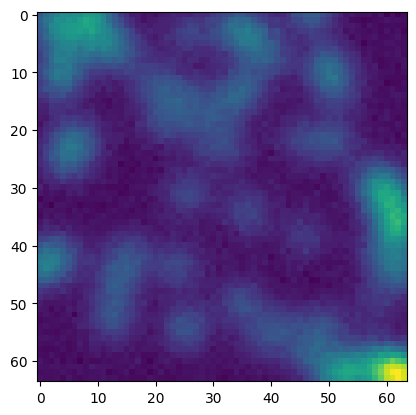

In [3]:
for i in range(1):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")
    fig, img = plt.subplots(1,1)
    _ = img.imshow(images[i].cpu())

### Perform inference with SMC

We set the side length of the tiles on which we will run the sampler, and we specify a prior and image model at the tile level. We also specify a mutation kernel to be used within the SMC sampler.

In [4]:
tile_dim = 8

TilePrior = StarPrior(max_objects = 3,
                      image_dim = tile_dim,
                      min_flux = 10000,
                      pad = 2)

TileImageModel = ImageModel(image_dim = tile_dim,
                            psf_stdev = 3,
                            background = 20000)

MHKernel = MetropolisHastings(num_iters = 50,
                              locs_stdev = 0.25,
                              features_stdev = 1250)

Now we initialize an `SMCsampler` object and run it on the tiles.

In [5]:
smc = SMCsampler(image = images[0],
                 tile_dim = tile_dim,
                 Prior = TilePrior,
                 ImageModel = TileImageModel,
                 MutationKernel = MHKernel,
                 num_catalogs_per_count = 500,
                 max_smc_iters = 500)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()

True count: 56
True total flux: 5490589.0

Starting the tile samplers...
iteration 5, temperature = 0.005010553635656834
iteration 10, temperature = 0.05010689049959183
iteration 15, temperature = 0.2913079857826233
Done!

summary
number of SMC iterations: 19
